# Final Report: Health Insurance Costs

## Introduction
### Background
Healthcare costs are a significant public health issue, especially in the United States, where costs are relatively more expensive. Thus, it is crucial to understand and identify potential factors that contribute to higher insurance premiums.

One such factor is gender, which companies have traditionally used to help determine a policyholder's risk. Studies have demonstrated that there are persistent disparities in healthcare premiums across genders, with women usually paying higher premiums. Insurance companies claim that this is because women go the hospital more, but many activists criticize this gender gap. Thus, we investigate a dataset containing the medical costs of American individuals billed by health insurance companies. Based on this sample, we want to explore whether insurance companies are really spending more on healthcare bills for women, as suggested by their premiums. To justify women paying highier premiums, one should expect that women are incurring higher medical costs than men for insurance companies. 

### Question
We are interested in exploring whether insurance companies should consider gender when setting premiums and which gender requires more reimbursement from the insurance company.


From a cursory examination of the dataset, we learn that the mean charge for men is \\$13,956.75 while the mean charges for women is \\$12,569.58. This means that men  require more reimbursement in healthcare costs than women in this particular sample, which is incongruent with women paying higher premiums. Therefore, we will use statistical inference to determine whether men require more reimbursement from insurance companies. Our guiding hypothesis is: **“Men incur higher medical costs for healthcare insurance companies on average than women.”** 

## Methods and Results
To make our answer trustworthy, our results should be data-based and derived by data analysis. To achieve this, we will conduct a “hypothesis testing” learnt from this course as our methodology. We will start by specifying our null hypothesis as the status quo: "Women incur as much, if not more, medical costs than men." Our alternative hypothesis is: “Men incur higher medical costs than women." 

$$H_0: \mu_{\text{male}} - \mu_{\text{female}} ≤ 0$$ $$H_1: \mu_{\text{male}} - \mu_{\text{female}} > 0$$


We choose a 5% significance level. We choose this significance level because it is a relatively standard value to use and it is a rule of thumb within the statistical coumminity.

### Data
Our dataset is from Kaggle[[1]](https://www.kaggle.com/datasets/mirichoi0218/insurance), and the population is US citizens. The dataset has seven columns, but we only use two of them:

|column|description| 
| ---  | --- | 
| sex  | insurance contractor gender, female, male |
|charges| Individual medical costs billed by health insurance |

Our random variable of interest is the charge spread across the sex. Our location parameter is the mean of charges for different gender. We will use simulation-based methods, creating a confidence interval by using standard deviation of our estimate and using the bootstrapping method to compute the standard error. We will also conduct a hypothesis test using theory-based methods. 

### Importing Libraries; Reading and Wrangling Dataset
We will use tidyverse to read, tidy, manipulate, visual data and so on. Repr is used to resize plots, dplyr for data wrangling, infer package for statistical inference, and cowplot for creating high-quality figures. And ggpairs from GGally is very useful method.

In [1]:
library(cowplot)
library(dplyr)
library(tidyverse)
library(repr)
library(infer)
library(GGally)
library(broom)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
# Read dataset, and name it as insurance
insurance <- read.csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

# Inspect the head and tail rows
head(insurance)
tail(insurance)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.900,0,yes,southwest,16884.924
2,18,male,33.770,1,no,southeast,1725.552
3,28,male,33.000,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.471
5,32,male,28.880,0,no,northwest,3866.855
6,31,female,25.740,0,no,southeast,3756.622


,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1333,52,female,44.70,3,no,southwest,11411.685
1334,50,male,30.97,3,no,northwest,10600.548
1335,18,female,31.92,0,no,northeast,2205.981
1336,18,female,36.85,0,no,southeast,1629.833
1337,21,female,25.80,0,no,southwest,2007.945
1338,61,female,29.07,0,yes,northwest,29141.360


In [3]:
# Select the columns we need
insurance <- insurance %>%
    select(sex, charges)

head(insurance)

,sex,charges
,<chr>,<dbl>
1,female,16884.924
2,male,1725.552
3,male,4449.462
4,male,21984.471
5,male,3866.855
6,female,3756.622


In [4]:
# Check number of NAs in sex and charges columns
na_sex <- sum(is.na(insurance$sex)) 
na_charges <- sum(is.na(insurance$charges))

print(sprintf("The number of na in the sex column: %d", na_sex))
print(sprintf("The number of na in the charges column: %d", na_charges))

[1] "The number of na in the sex column: 0"
[1] "The number of na in the charges column: 0"


Since there are no NA values in the two columns, we do not need to remove any rows.

### Visualize the data
We will use plot to help us get a better sense of our dataset. We decide to use boxplot which allows us to compare our variables.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


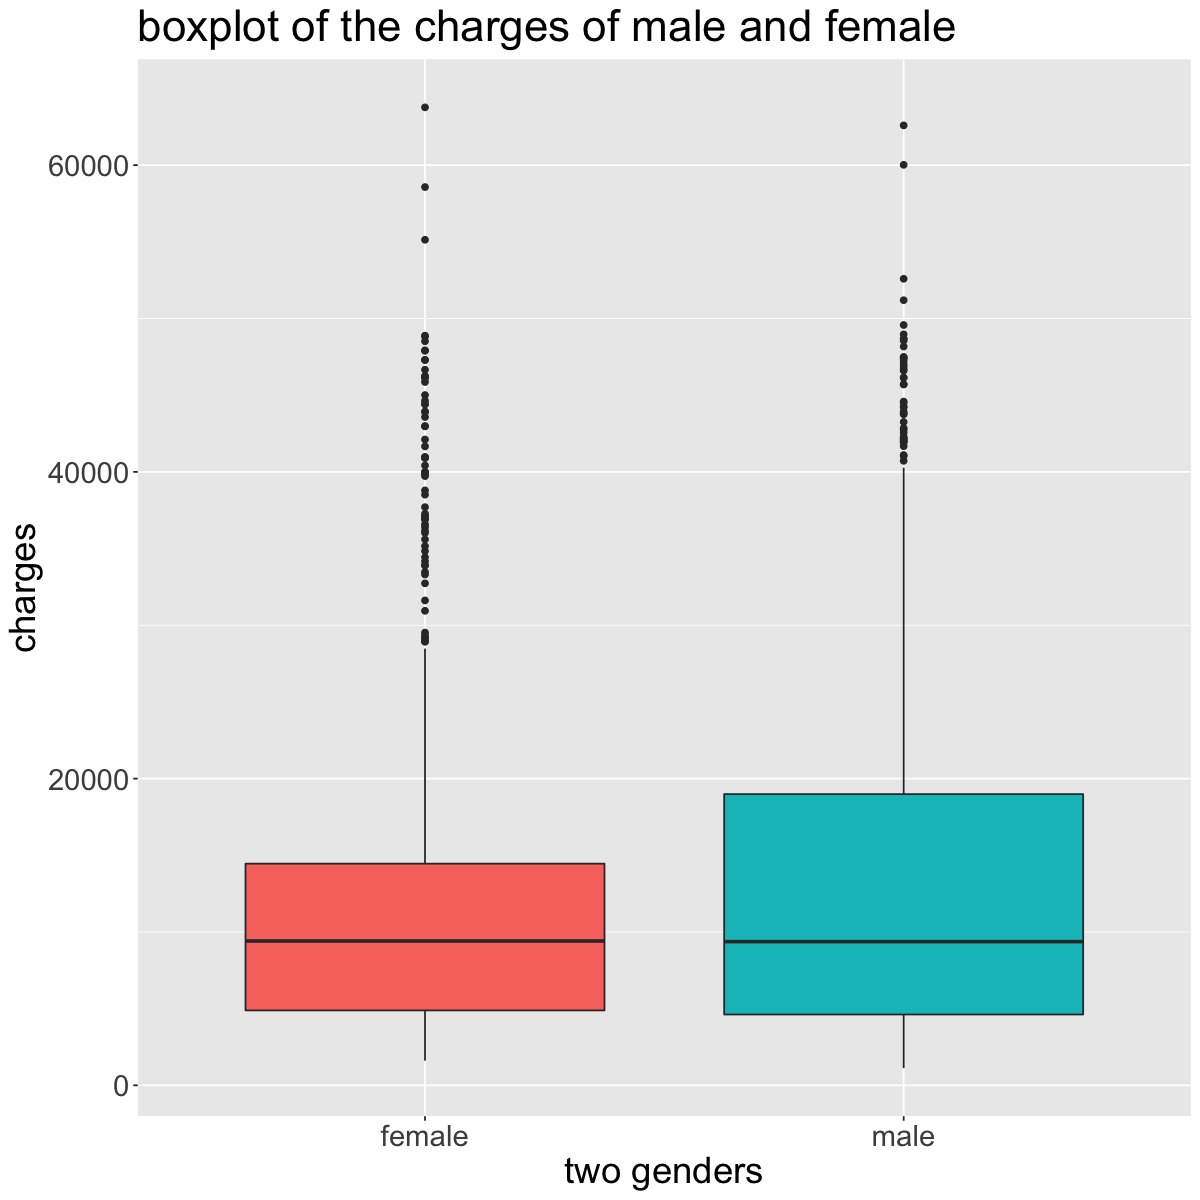

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10)

boxplots <-
    insurance %>% 
    ggplot() +
    geom_boxplot(aes(sex, charges, fill = sex)) +
    theme(text = element_text(size = 22)) +
    ggtitle("boxplot of the charges of male and female") + 
    xlab("two genders") + 
    ylab("charges") + 
    guides(fill = FALSE)

boxplots

From the box plot, we can see our dataset has a large range, and the IQR of the male is greater than female. And the mean of females and males are very close, it's hard to compare them in the box plot.

### Bootstrapping
#### Using simulation-based
Firstly, we conduct a hypothesis test using a simulation-based method. We will bootstrap the sample to get multiple test statistics to mimic the behaviour of sampling distribution. By CLT, the bootstrapped estimates should be a normal distribution. The null hypothesis, therefore, should follow a normal distribution that has “mean = 0”, and “standard error = standard deviation of bootstrapped estimates”. We can then derive the p-value under the distribution of the null hypothesis. Finally, by setting up the significance level, we can determine whether to reject the null hypothesis or not. Potential errors can be identified in the final steps and plots are along the way to help us visualize results.

In [6]:
# Compute our observed difference in means
obs_diff_means <- insurance %>% 
    specify(formula = charges ~ sex) %>% 
    calculate(stat = 'diff in means', order = c('male', 'female'))
obs_diff_means

stat
<dbl>
1387.172


p_value
<dbl>
0.019


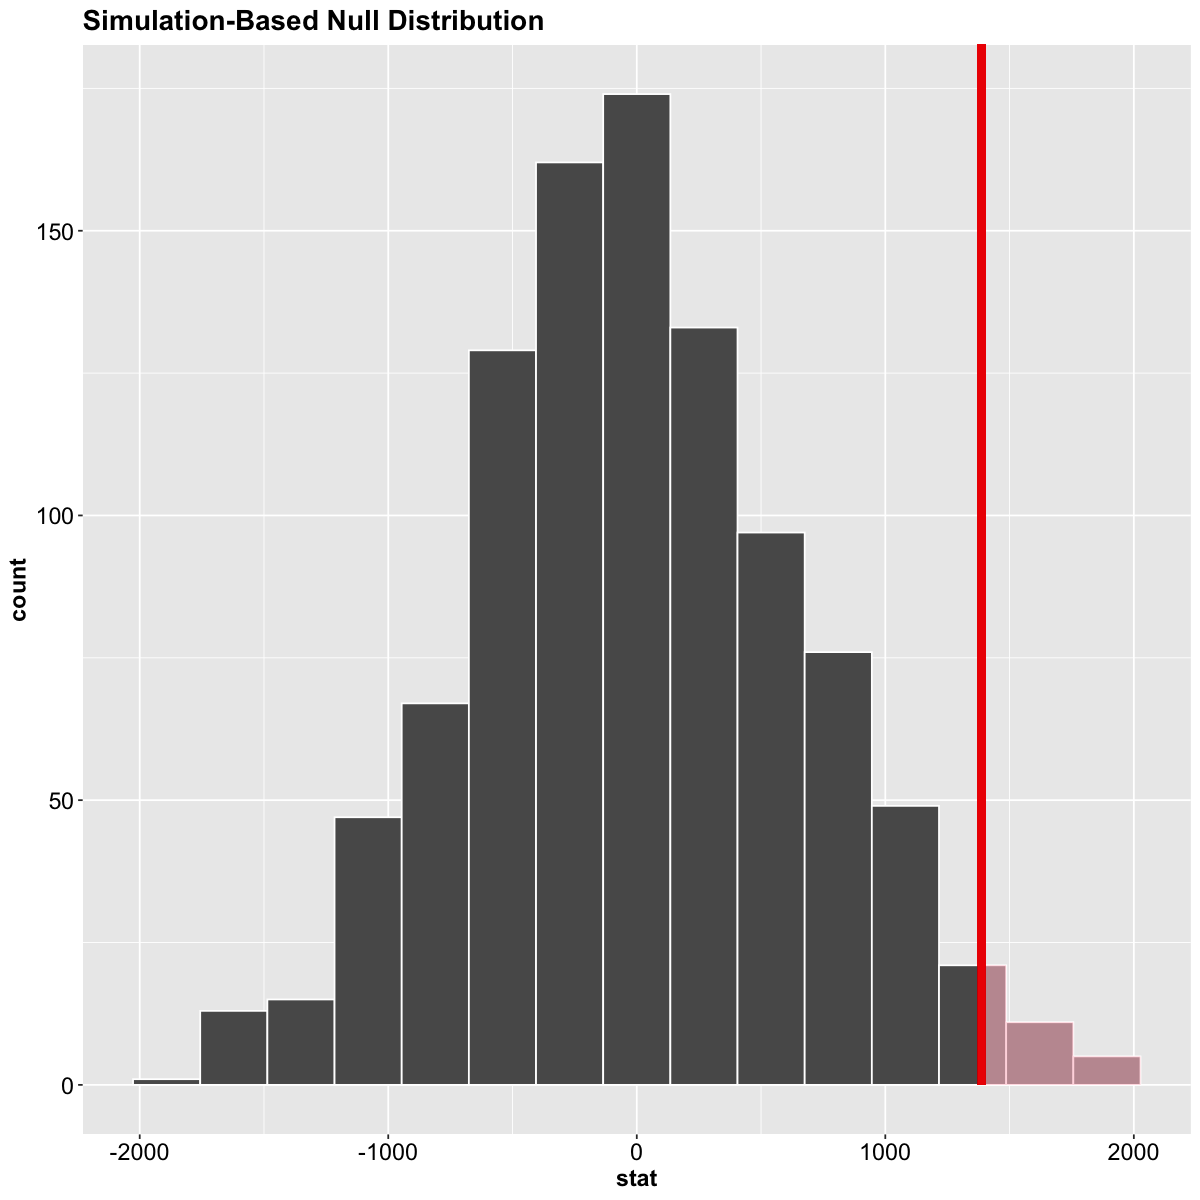

In [7]:
options(repr.plot.width = 10, repr.plot.height = 10)

set.seed(1234)

# Get the null distribution by using infer workflow
null_dist <- insurance %>% 
    specify(formula = charges ~ sex) %>% 
    hypothesize(null = 'independence') %>% 
    generate(reps = 1000, type = 'permute') %>% 
    calculate(stat = 'diff in means', order = c('male', 'female')) 

# Visualize null distribution
visualize(null_dist) + 
    shade_p_value(obs_stat = obs_diff_means, direction = 'right') +
    theme(axis.text = element_text(color = "black", size = 14),
         axis.title = element_text(size=14,color='black',face='bold'),
         title =element_text(size=14, face='bold'))

# Compute the p-value by using our test statistic
null_dist %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "right")

We will do a interpretaion of the p-value with 5% significance level. Since the p-value is smaller than 0.05, we **reject the null hypothesis at a 5% significance level**, which means men incur higher medical costs for healthcare insurance companies on average than women.

#### Confidence Intervals via Bootstrapping
We will construct the confidence interval via bootstrapping. Bootstrapping refers to construct an approximation to the sampling distribution using only one sample. We will use infer package workflow to help us. 

lower_ci,upper_ci
<dbl>,<dbl>
59.46837,2760.515


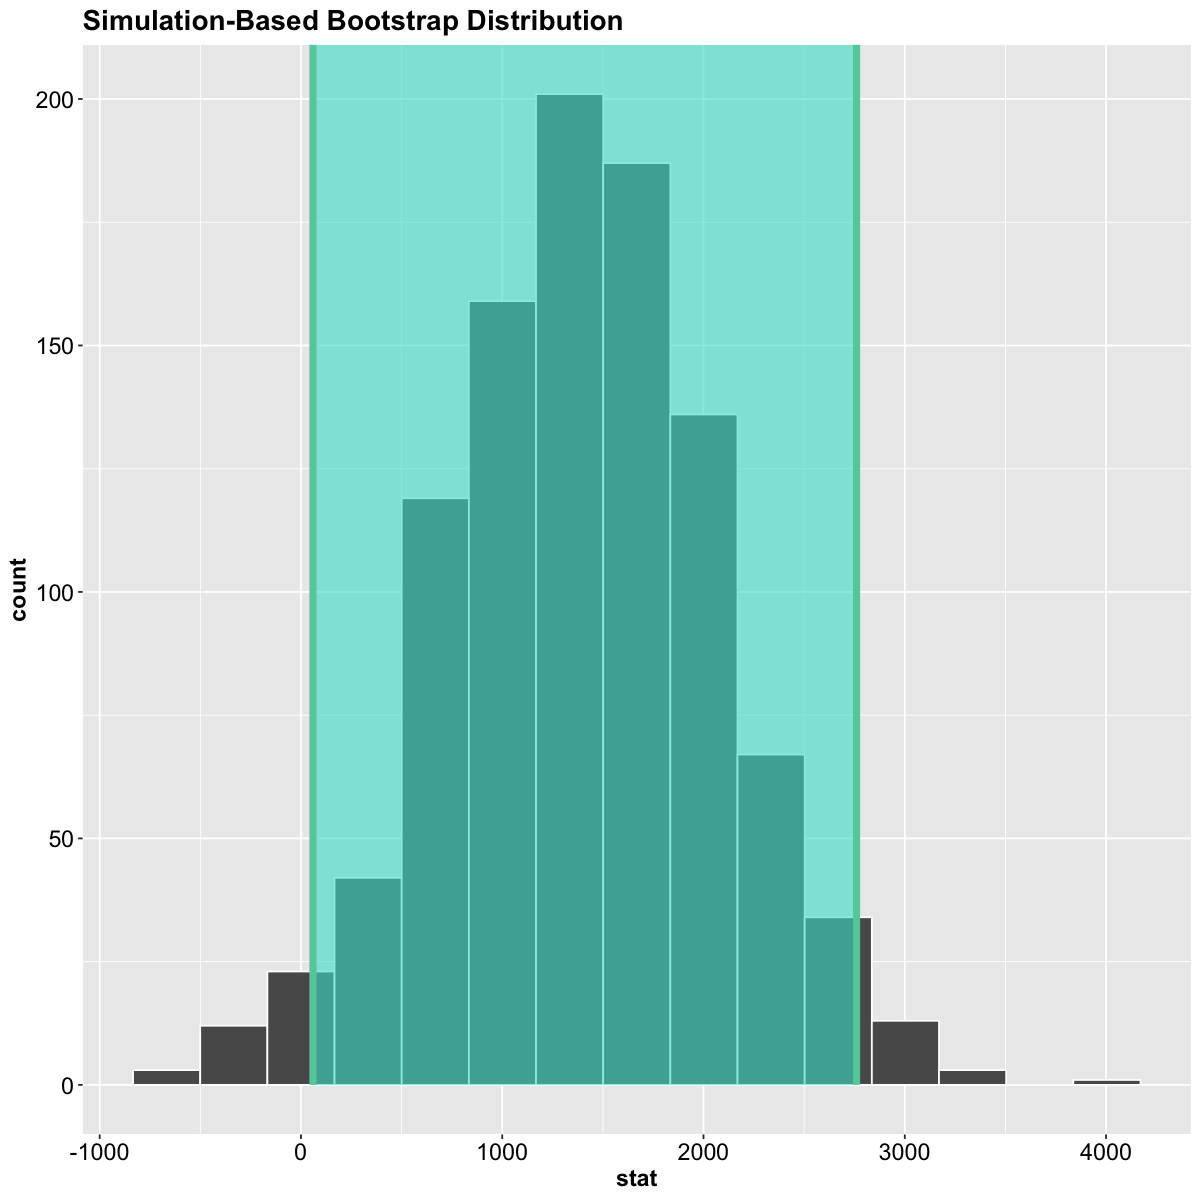

In [8]:
options(repr.plot.width = 10, repr.plot.height = 10)

set.seed(1234)

# Generate the bootstrap distribution
bootstrap_dist <- insurance %>% 
  specify(formula = charges ~ sex) %>% 
  generate(reps = 1000, type = 'bootstrap') %>% 
  calculate(stat = 'diff in means', order = c('male', 'female')) 

# Compute confidence interval by percentile method
percentile_ci <- bootstrap_dist %>%
    get_ci(level = 0.95, type = 'percentile') 
percentile_ci

# Visualize the confidence interval
visualize(bootstrap_dist) + 
    shade_ci(endpoints = percentile_ci) +
    theme(axis.text = element_text(color = "black", size = 14),
         axis.title = element_text(size=14,color='black',face='bold'),
         title =element_text(size=14, face='bold'))

We are 95% confident that the true difference in means, $\mu_{\text{male}} - \mu_{\text{female}}$, lies between (129.0345, 2599.685). 

The confidence interval does not contain 0, suggesting that $\mu_{\text{male}}$ and $\mu_{\text{female}}$ are different. Furthermore, the entire confidence interval lies above 0, suggesting that $\mu_{\text{male}}$ is greater than $\mu_{\text{female}}$.

### Asymptotics
#### Using theory-based CLT

Next, we use a theory-based approach to conduct an independent two-sample t-test of independent populations.

We will use the following test statistic:
$$
T = \frac{\bar{x}_{\text{male}} - \bar{x}_{\text{female}}}{\sqrt{\frac{s^2_{\text{male}}}{n_1}+\frac{s^2_{\text{female}}}{n_2}}}
$$

where $\bar{x}_{\text{male}}$ and $\bar{x}_{\text{female}}$ are the sample means of charges for male and female; $s^2_{\text{male}}$ and $s^2_{\text{female}}$ are the sample variances for male and female; and $n_1$ and $n_2$ are the sample size for male and female. 

$t$-distribution has approximately $\nu$ degrees of freedom, where 
$$
\nu = \frac{
    \left(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}\right)^2}
{
\frac{s_1^4}{n_1^2(n_1-1)}+\frac{s_2^4}{n_2^2(n_2-1)}
}
$$
At first, we will compute the needed summary statistics, and these values will be used to calculate test statistics.

In [9]:
# Summarizing the sample statistics needed to calculate the test statistic and degrees of freedom
insurance_summary <- insurance %>% 
    group_by(sex) %>%
    summarize(n = n(), 
              sample_mean = mean(charges), 
              sample_var = var(charges), 
              `.groups` = 'drop') %>% 
    pivot_wider(names_from = sex, 
                values_from = n:sample_var) %>% 
    mutate(mean_diff = sample_mean_male - sample_mean_female)

insurance_summary

n_female,n_male,sample_mean_female,sample_mean_male,sample_var_female,sample_var_male,mean_diff
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
662,676,12569.58,13956.75,123848048,168247513,1387.172


Before we use the theory-based approach, we need to check the assumptions of CLT. 
- The data are sampled randomly.
- The data are independent of each other.
- The sample size is big enough, n > 30.

In [10]:
# Calculating test statistic
obs_test_stat <- (insurance_summary$sample_mean_male - insurance_summary$sample_mean_female) / 
    sqrt(insurance_summary$sample_var_male/insurance_summary$n_male + 
         insurance_summary$sample_var_female/insurance_summary$n_female)

obs_test_stat

[1] 2.100888

In [11]:
# Calculating null model t-distribution with approx. v degrees of freedom
df = (insurance_summary$sample_var_male/insurance_summary$n_male + 
      insurance_summary$sample_var_female/insurance_summary$n_female)^2 / 
    (insurance_summary$sample_var_male^2/(insurance_summary$n_male^2*(insurance_summary$n_male-1)) + 
     insurance_summary$sample_var_female^2/(insurance_summary$n_female^2*(insurance_summary$n_female-1)))

df

[1] 1313.36

In [12]:
# Calculating p-value
p_value <- pt(obs_test_stat, df, lower.tail = FALSE)
p_value

[1] 0.01792051

We arrive at a p-value of approximate 0.0179. Since this p-value is less than our significance level of 0.05, **we reject the null hypothesis**, which means men incur higher medical costs for healthcare insurance companies on average than women.

We easily verify that our theory-based method is correct by using the t.test() function.

In [13]:
t_test <- t.test(x = insurance %>% filter(sex == 'male') %>% pull(charges), 
                 y = insurance %>% filter(sex == 'female') %>% pull(charges),
                 alternative = "greater") %>%
    tidy()

p_value2 <- t_test$p.value

t_test
p_value2

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1387.172,13956.75,12569.58,2.100888,0.01792051,1313.36,300.3432,Inf,Welch Two Sample t-test,greater


[1] 0.01792051

We get the same value.

#### Confidence Intervals via Asymptotics
We will construct confidence interval via asymptotics.

Assuming the sample size is large enough, we can approximate the sampling distribution of $\bar{x}_{\text{male}}-\bar{x}_{\text{female}}$ by
$$
\bar{x}_{\text{male}}-\bar{x}_{\text{female}}\sim N\left(\mu_1 - \mu_2, \sqrt{\frac{s^2_{\text{male}}}{n_1}+\frac{s^2_{\text{female}}}{n_2}}\right)
$$

Therefore, you can obtain the confidence interval as

$$
CI\left(\mu_1 - \mu_2\right) = \left(\bar{x}_{\text{male}}-\bar{x}_{\text{female}}\right) \pm z^*\sqrt{\frac{s^2_{\text{male}}}{n_1}+\frac{s^2_{\text{female}}}{n_2}}
$$
where $\bar{x}_{\text{male}}$ and $\bar{x}_{\text{female}}$ are the sample means of charges for male and female; $s^2_{\text{male}}$ and $s^2_{\text{female}}$ are the sample variances for male and female; and $n_1$ and $n_2$ are the sample size for male and female. And $z^*$ is the quantile of a standard Normal.

We will check the assumptions of CLT.
- The data are sampled randomly.
- The data are independent of each other.
- The sample size is big enough, n > 30.

Now let's compute the 95% confidence interval.

In [20]:
# select the charges for female
female <- 
    insurance %>% 
    filter(sex == 'female') %>% 
    pull(charges)

# select the charges for male
male <- 
    insurance %>% 
    filter(sex == 'male') %>% 
    pull(charges)

# compute confidence interval using qnorm
charges_diff_means_ci <- 
    tibble(
        lower_ci = mean(male, na.rm = TRUE) - mean(female, na.rm = TRUE) - qnorm(0.975,mean=0,sd=1) * 
            sqrt(var(male, na.rm = TRUE)/length(male) + var(female, na.rm = TRUE)/length(female)),
        upper_ci = mean(male, na.rm = TRUE) - mean(female, na.rm = TRUE) + qnorm(0.975,mean=0,sd=1) * 
            sqrt(var(male, na.rm = TRUE)/length(male) + var(female, na.rm = TRUE)/length(female)),
    )

# your code here

charges_diff_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
93.04907,2681.296


We are 95% confident that the true difference in means, $\mu_{\text{male}} - \mu_{\text{female}}$, lies between (93.049, 2681.296). 

The confidence interval does not contain 0, suggesting that $\mu_{\text{male}}$ and $\mu_{\text{female}}$ are different. Furthermore, the entire confidence interval lies above 0, suggesting that $\mu_{\text{male}}$ is greater than $\mu_{\text{female}}$.

### Comparsion of Bootstrapping and Asymptotics
Both the simulation-based test and the theory-based test result in the same conclusion, where we reject the null hypothesis. The two p-values and confidence intervals are close. But using theory based method relied on many assumptions, for example, we need a 'large enough' sample size, we can't fully guarantee that our size is always up to the standard. On the other hand, bootstrapping does not rely on assumptions, because the sampling distribution can be observed since we can resample the original sample to create many samples.

Thus, we prefer bootstrapping method.

## Discussion 
By evidence-based analysis on sample data, this report gives straightforward answer to the question that whether gender is a significant factor of medical cost in US. In our hypothesis test analysis, both simulation-based and theory-based methods produce a p-value less than significance level 5%, which is significant for us to reject our null hypothesis. Based on these findings, we believe that contrary to the claims of insurance companies, **women do NOT incur higher medical costs than men.** We anticipate the impact of our findings will help insurance companies set fairer premiums. 

This result is expected, as the preliminary results already showed the IQR of medical cost by men is higher than that of women, as also the fact that men have higher mean medical cost than that of women in our sample.

This finding can contribute to a more comprehensive understanding of the factors that influence the medical cost for US medical service companies. For future studies, as this report is limited to US citizens, it is possible for future analysis on this question to expand their scale on more nations or continents, to see whether this finding (men have higher medical cost) is worldwide or only subject to US.

## References

1. Choi, M. (2018, February 21). Medical Cost Personal Datasets. Kaggle. Retrieved November 4, 2022, from https://www.kaggle.com/datasets/mirichoi0218/insurance 

2. Women pay higher premiums than men of the same age for identical individual health insurance policies, Data Show. Kaiser Health News. (2009, June 11). Retrieved November 4, 2022, from https://khn.org/morning-breakout/dr00055285/ 

3. How health insurance premium prices vary based on gender. Acko General Insurance. (2022, October 25). Retrieved November 4, 2022, from https://www.acko.com/health-insurance/gender-based-health-premium-plans/ 